![](./resources/System_v1_custom_croptype.png)

**Table of contents**<a id='toc0_'></a>    
- [Before you start](#toc1_)    
- [Define a region of interest](#toc2_)    
- [Extract public training data](#toc3_)    
- [Select desired crops for prediction](#toc4_)    
- [Extract required model inputs](#toc5_)    
- [Train custom classification model](#toc6_)    
- [Deploy custom model](#toc7_)    
- [Generate a map](#toc8_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc1_'></a>[Before you start](#toc0_)

In order to run WorldCereal crop mapping jobs from this notebook, you need to create an account on the Copernicus Data Space Ecosystem (CDSE) registering [here](https://dataspace.copernicus.eu/). This is free of charge and will grant you a number of free openEO processing credits to continue this demo.

In [5]:
# TEMPORARY CELL

import sys
sys.path.append('/home/jeroendegerickx/git/worldcereal/worldcereal-classification/notebooks')
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# <a id='toc2_'></a>[Define a region of interest](#toc0_)

When running the code snippet below, an interactive map will be visualized.
Click the Rectangle button on the left hand side of the map to start drawing your region of interest.
Currently, there is a maximum size of 250 km² for your area within this demo. Upon exceeding this limit, an error will be shown.
The widget will automatically store the coordinates of the last rectangle you drew on the map.

In [2]:
from worldcereal.utils.map import ui_map

map = ui_map()
map.show_map()

Map(center=[51.1872, 5.1154], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoo…

2024-10-14 19:08:09.833 | INFO     | worldcereal.utils.map:handle_draw:13 - Your processing extent: (10.349941, 53.119306, 10.408676, 53.145054)
2024-10-14 19:08:09.915 | INFO     | worldcereal.utils.map:handle_draw:19 - Area of processing extent: 11.71 km²


# <a id='toc3_'></a>[Extract public training data](#toc0_)

Here we query existing reference data that have already been processed by WorldCereal and are ready to use.
To increase the number of hits, we expand the search area by 250 km in all directions.

In [3]:
from worldcereal.utils.refdata import query_public_extractions

# retrieve the polygon you just drew
polygon = map.get_polygon_latlon()

# Query our public database of training data
public_df = query_public_extractions(polygon)
public_df.year.value_counts()

2024-10-14 19:08:17.731 | INFO     | worldcereal.utils.map:get_processing_extent:112 - Your processing extent: (10.349941, 53.119306, 10.408676, 53.145054)
2024-10-14 19:08:17.733 | INFO     | worldcereal.utils.refdata:query_public_extractions:51 - Applying a buffer of 250 km to the selected area ...
2024-10-14 19:08:17.892 | INFO     | worldcereal.utils.refdata:query_public_extractions:81 - Querying WorldCereal global extractions database (this can take a while) ...
2024-10-14 19:08:35.070 | INFO     | worldcereal.utils.refdata:process_parquet:127 - Processing selected samples ...
2024-10-14 19:08:35.463 | INFO     | worldcereal.utils.refdata:process_parquet:130 - Extracted and processed 582 samples from global database.


year
2018    582
Name: count, dtype: int64

# <a id='toc4_'></a>[Select desired crops for prediction](#toc0_)

Run the next cell and select all crop types you wish to include in your model. All the crops that are not selected will be grouped under the "other_crop" category. The model will be trained in a multi-class setting.

In [6]:
from utils import pick_croptypes
from IPython.display import display

checkbox, checkbox_widgets = pick_croptypes(public_df, samples_threshold=100)
display(checkbox)

Based on your selection, a custom target label is now generated for each sample. Verify that only crops of your choice are appearing in the `downstream_class`, all others will fall under `other`.

In [7]:
from utils import get_custom_croptype_labels

public_df = get_custom_croptype_labels(public_df, checkbox_widgets)
public_df["downstream_class"].value_counts()

downstream_class
other                252
unspecified_wheat    192
maize                138
Name: count, dtype: int64

# <a id='toc5_'></a>[Extract required model inputs](#toc0_)

Here we prepare presto inputs features for each sample by using a model pretrained on WorldCereal data. The resulting `encodings` and `targets` will be used for model training.

In [8]:
from utils import prepare_training_dataframe

training_dataframe = prepare_training_dataframe(public_df, task_type="croptype")

2024-10-14 19:09:21.714 | INFO     | utils:prepare_training_dataframe:324 - Presto URL: https://artifactory.vgt.vito.be/artifactory/auxdata-public/worldcereal/models/PhaseII/presto-ss-wc-ft-ct_croptype_CROPTYPE0_30D_random_time-token=month_balance=True_augment=True.pt


2024-10-14 19:09:21.893 | INFO     | worldcereal.train.data:__init__:35 - Augmentation is enabled.     The horizontal jittering of the selected window will be performed.
2024-10-14 19:09:21.895 | INFO     | worldcereal.train.data:__init__:51 - Original dataset size: 582
2024-10-14 19:09:21.896 | INFO     | worldcereal.train.data:__init__:57 - Dataset size after 1 repeats: 582
2024-10-14 19:09:21.896 | INFO     | utils:prepare_training_dataframe:340 - Computing Presto embeddings ...
100%|██████████| 3/3 [00:02<00:00,  1.14it/s]
2024-10-14 19:09:24.543 | INFO     | utils:prepare_training_dataframe:348 - Done.


# <a id='toc6_'></a>[Train custom classification model](#toc0_)
We train a catboost model for the selected crop types. Class weights are automatically determined to balance the individual classes.

In [9]:
from utils import train_classifier

custom_model, report, confusion_matrix = train_classifier(training_dataframe)

2024-10-14 19:09:31.606 | INFO     | utils:train_classifier:395 - Split train/test ...
2024-10-14 19:09:31.617 | INFO     | utils:train_classifier:414 - Computing class weights ...
2024-10-14 19:09:31.621 | INFO     | utils:train_classifier:427 - Class weights: {'maize': 1.409, 'other': 0.771, 'unspecified_wheat': 1.006}
2024-10-14 19:09:31.661 | INFO     | utils:train_classifier:467 - Training CatBoost classifier ...


Learning rate set to 0.04805
0:	learn: 1.0586911	test: 1.0637480	best: 1.0637480 (0)	total: 91.7ms	remaining: 12m 13s
25:	learn: 0.5650713	test: 0.6863680	best: 0.6863680 (25)	total: 768ms	remaining: 3m 55s
50:	learn: 0.3771754	test: 0.5571138	best: 0.5571138 (50)	total: 1.39s	remaining: 3m 36s
75:	learn: 0.2801689	test: 0.4972990	best: 0.4972990 (75)	total: 2.04s	remaining: 3m 32s
100:	learn: 0.2221873	test: 0.4668236	best: 0.4668236 (100)	total: 2.64s	remaining: 3m 26s
125:	learn: 0.1820294	test: 0.4457419	best: 0.4457419 (125)	total: 3.2s	remaining: 3m 20s
150:	learn: 0.1503336	test: 0.4347274	best: 0.4347274 (150)	total: 3.78s	remaining: 3m 16s
175:	learn: 0.1263781	test: 0.4280751	best: 0.4280751 (175)	total: 4.35s	remaining: 3m 13s
200:	learn: 0.1079100	test: 0.4259335	best: 0.4256174 (197)	total: 4.92s	remaining: 3m 11s
225:	learn: 0.0934925	test: 0.4247271	best: 0.4247271 (225)	total: 5.49s	remaining: 3m 8s
250:	learn: 0.0830328	test: 0.4214331	best: 0.4214331 (250)	total: 6.07

In [10]:
# Print the classification report
print(report)

                   precision    recall  f1-score   support

            maize       0.84      0.93      0.88        28
            other       0.85      0.80      0.83        51
unspecified_wheat       0.82      0.82      0.82        38

         accuracy                           0.84       117
        macro avg       0.84      0.85      0.84       117
     weighted avg       0.84      0.84      0.84       117



# <a id='toc7_'></a>[Deploy custom model](#toc0_)

Once trained, we have to upload our model to the cloud so it can be used for inference. Note that these models are only kept in cloud storage for a limited amount of time.


In [11]:
from worldcereal.utils.upload import deploy_model
from openeo_gfmap.backend import cdse_connection

model_url = deploy_model(cdse_connection(), custom_model, pattern="demo_croptype_multiclass_DE")

2024-10-14 19:10:03.213 | INFO     | worldcereal.utils.upload:deploy_model:205 - Deploying model ...


Authenticated using refresh token.


2024-10-14 19:10:07.957 | INFO     | worldcereal.utils.upload:deploy_model:211 - Deployed to: s3://OpenEO-artifacts/fd307620ba8a0a07c44a2dc28541b181d5c03cb4/2024/10/14/demo_croptype_multiclass_DE_custommodel.onnx


# <a id='toc8_'></a>[Generate a map](#toc0_)

Using our custom model, we generate a map for our region and season of interest.
To determine your season of interest, you can consult the WorldCereal crop calendars (by executing the next cell), or check out the [USDA crop calendars](https://ipad.fas.usda.gov/ogamaps/cropcalendar.aspx).

2024-10-14 19:10:13.168 | INFO     | worldcereal.utils.map:get_processing_extent:112 - Your processing extent: (10.349941, 53.119306, 10.408676, 53.145054)


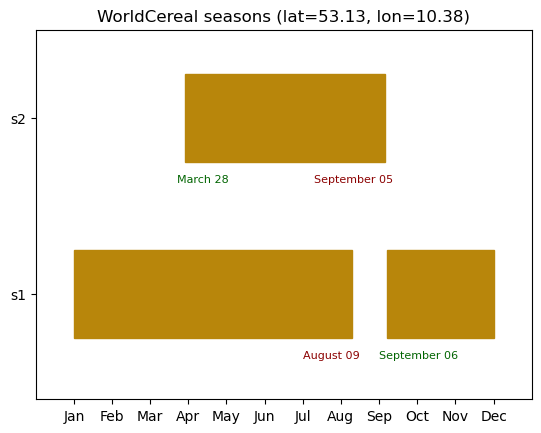

In [12]:
from utils import retrieve_worldcereal_seasons

spatial_extent = map.get_processing_extent()
seasons = retrieve_worldcereal_seasons(spatial_extent)

Now use the slider to select your processing period. Note that the length of the period is always fixed to a year.
Just make sure your season of interest is fully captured within the period you select.

In [13]:
from utils import date_slider

slider = date_slider()
slider.show_slider()

Set some other customization options:

In [14]:
from worldcereal.job import PostprocessParameters
import os
from pathlib import Path

# Choose whether you want to store the cropland mask as separate output file (default = False)
save_mask = True

# Choose whether or not you want to spatially clean the classification results (default = True)
postprocess_result = True
# Choose the postprocessing method you want to use ["smooth_probabilities", "majority_vote"] (default = "smooth_probabilities")
postprocess_method = "majority_vote"
# Additiona parameters for the majority vote method:
kernel_size = 5 # default = 5
# Do you want to save the intermediate results (before applying the postprocessing)
save_intermediate = True #default is False
# Do you want to save all class probabilities in the final product? (default is False)
keep_class_probs = True

postprocess_parameters = PostprocessParameters(enable=postprocess_result,
                                               method=postprocess_method,
                                               kernel_size=kernel_size,
                                               save_intermediate=save_intermediate,
                                               keep_class_probs=keep_class_probs)

# Specify the local directory where the resulting maps should be downloaded to.
output_dir = Path(os.getcwd()) / 'CROPTYPE_germany'
print(f"Output directory: {output_dir}")

Output directory: /home/jeroendegerickx/git/worldcereal/worldcereal-classification/CROPTYPE_germany


In [17]:
from worldcereal.job import WorldCerealProductType, generate_map, CropTypeParameters

# Initializes default parameters
parameters = CropTypeParameters()

# Change the URL to your custom classification model
parameters.classifier_parameters.classifier_url = model_url
parameters.save_mask = save_mask

# Get processing period and area
processing_period = slider.get_processing_period()
processing_extent = map.get_processing_extent()

# Launch the job
job_results = generate_map(
    processing_extent,
    processing_period,
    output_dir=output_dir,
    product_type=WorldCerealProductType.CROPTYPE,
    croptype_parameters=parameters,
    postprocess_parameters=postprocess_parameters,
)

2024-10-14 20:20:20.647 | INFO     | utils:get_processing_period:120 - Selected processing period: 2018-12-01 to 2019-11-30
2024-10-14 20:20:20.717 | INFO     | worldcereal.utils.map:get_processing_extent:112 - Your processing extent: (10.349941, 53.119306, 10.408676, 53.145054)
INFO:openeo.rest.connection:Found OIDC providers: ['CDSE']
INFO:openeo.rest.connection:No OIDC provider given, but only one available: 'CDSE'. Using that one.
INFO:openeo.rest.connection:Using default client_id 'sh-b1c3a958-52d4-40fe-a333-153595d1c71e' from OIDC provider 'CDSE' info.
INFO:openeo.rest.connection:Found refresh token: trying refresh token based authentication.
INFO:openeo.rest.auth.oidc:Doing 'refresh_token' token request 'https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token' with post data fields ['grant_type', 'client_id', 'refresh_token'] (client_id 'sh-b1c3a958-52d4-40fe-a333-153595d1c71e')
INFO:openeo.rest.connection:Obtained tokens: ['access_token', 'id_tok

Authenticated using refresh token.


2024-10-14 20:20:35,372 - openeo_gfmap.utils - INFO - Selected orbit state: ASCENDING. Reason: Orbit has more cumulative intersected area. 0.9639606281260852 > 0.5250584645381887
INFO:openeo_gfmap.utils:Selected orbit state: ASCENDING. Reason: Orbit has more cumulative intersected area. 0.9639606281260852 > 0.5250584645381887


0:00:00 Job 'j-2410145b1b3c43b8851ed611261b9ecb': send 'start'
0:00:20 Job 'j-2410145b1b3c43b8851ed611261b9ecb': running (progress N/A)
0:00:25 Job 'j-2410145b1b3c43b8851ed611261b9ecb': running (progress N/A)
0:00:32 Job 'j-2410145b1b3c43b8851ed611261b9ecb': running (progress N/A)
0:00:40 Job 'j-2410145b1b3c43b8851ed611261b9ecb': running (progress N/A)
0:00:50 Job 'j-2410145b1b3c43b8851ed611261b9ecb': running (progress N/A)
0:01:03 Job 'j-2410145b1b3c43b8851ed611261b9ecb': running (progress N/A)
0:01:19 Job 'j-2410145b1b3c43b8851ed611261b9ecb': running (progress N/A)
0:01:39 Job 'j-2410145b1b3c43b8851ed611261b9ecb': running (progress N/A)
0:02:03 Job 'j-2410145b1b3c43b8851ed611261b9ecb': running (progress N/A)
0:02:33 Job 'j-2410145b1b3c43b8851ed611261b9ecb': running (progress N/A)
0:03:11 Job 'j-2410145b1b3c43b8851ed611261b9ecb': running (progress N/A)
0:03:58 Job 'j-2410145b1b3c43b8851ed611261b9ecb': running (progress N/A)
0:04:57 Job 'j-2410145b1b3c43b8851ed611261b9ecb': running (pr

INFO:openeo.rest.job:Downloading Job result asset 'cropland-raw_20181201_20191130.tif' from https://openeo.creo.vito.be/openeo/jobs/j-2410145b1b3c43b8851ed611261b9ecb/results/assets/ZGNjYWI2ZDktODQ2Yy00OGE5LTlkOTQtNDk3MTQ2Y2IyMjg1/990ac36cfcb6a2797bcf85bfa5b3ed7c/cropland-raw_20181201_20191130.tif?expires=1729535690 to /home/jeroendegerickx/git/worldcereal/worldcereal-classification/CROPTYPE_germany/cropland-raw_20181201_20191130.tif
INFO:openeo.rest.job:Downloading Job result asset 'cropland_20181201_20191130.tif' from https://openeo.creo.vito.be/openeo/jobs/j-2410145b1b3c43b8851ed611261b9ecb/results/assets/ZGNjYWI2ZDktODQ2Yy00OGE5LTlkOTQtNDk3MTQ2Y2IyMjg1/1199815155d5ed90ed8be9d0eede8b30/cropland_20181201_20191130.tif?expires=1729535690 to /home/jeroendegerickx/git/worldcereal/worldcereal-classification/CROPTYPE_germany/cropland_20181201_20191130.tif
INFO:openeo.rest.job:Downloading Job result asset 'croptype-raw_20181201_20191130.tif' from https://openeo.creo.vito.be/openeo/jobs/j-24

The classification results will be automatically downloaded to your output_dir in .tif format.
By default, OpenEO stores the class labels, confidence score and class probabilities in one file.

Using the function below, we split this information into separate .tif files, thereby adding metadata and a color map, to ease interpretation and visualization:
- "xxx_classification_start-date_end-date.tif" --> contains the classification labels. A class look-up table is included in the .tif metadata.
- "xxx_confidence_start-date_end-date.tif" -->  contains the probability associated to the prediction [0 - 100]

In case you chose to store the original per-class probabilities, these are NOT written to a separate file and need to be consulted in the original result downloaded from OpenEO.

In [18]:
from utils import prepare_visualization

rasters = prepare_visualization(job_results)
print(rasters)

2024-10-14 20:35:48.639 | INFO     | utils:_get_colormap:540 - Assigning random color map for product croptype. 


{'cropland-raw': {'classification': PosixPath('/home/jeroendegerickx/git/worldcereal/worldcereal-classification/CROPTYPE_germany/cropland-raw_classification_20181201_20191130.tif'), 'confidence': PosixPath('/home/jeroendegerickx/git/worldcereal/worldcereal-classification/CROPTYPE_germany/cropland-raw_confidence_20181201_20191130.tif')}, 'cropland': {'classification': PosixPath('/home/jeroendegerickx/git/worldcereal/worldcereal-classification/CROPTYPE_germany/cropland_classification_20181201_20191130.tif'), 'confidence': PosixPath('/home/jeroendegerickx/git/worldcereal/worldcereal-classification/CROPTYPE_germany/cropland_confidence_20181201_20191130.tif')}, 'croptype-raw': {'classification': PosixPath('/home/jeroendegerickx/git/worldcereal/worldcereal-classification/CROPTYPE_germany/croptype-raw_classification_20181201_20191130.tif'), 'confidence': PosixPath('/home/jeroendegerickx/git/worldcereal/worldcereal-classification/CROPTYPE_germany/croptype-raw_confidence_20181201_20191130.tif')

The resulting raster files can be visualized in QGIS, or using the function in the cell below...

In [25]:
from utils import visualize_products

visualize_products(rasters, port=8887)

Map(center=[53.1321915, 10.379311000000001], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_…

Finally, use the cell below to visualize the look-up table for the classification product.

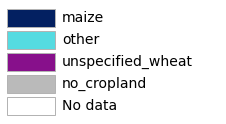

In [24]:
from utils import show_color_legend

show_color_legend(rasters, "croptype")